## Welcome to version 2

TODO LIST:
- Error when downloading images, currently only working with filteres positive images
- Create a trainable linear map for feature extraction
- Propose using (sentnce,img) as opposed to (sentence,img,img)

==

- Split the data in train, dev, and test
- Create labels with the dataframe
- Remove articles from sentences

#### Imports

In [64]:
import os
import requests
import pandas as pd
from PIL import Image
import io
import numpy as np
from torch import nn

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from sklearn.decomposition import PCA

from lambeq.backend.grammar import Ty, Box 
from lambeq import BobcatParser, AtomicType, Sim14Ansatz, RemoveCupsRewriter

import matplotlib.pyplot as plt

print("All libraries are successfully imported!")

All libraries are successfully imported!


#### Dataset and Image pre-processing

Dataset extraction

In [5]:
# Read the CSV file
file_path = os.path.join(os.getcwd(), "database.csv")
df = pd.read_csv(file_path)

# Extract the sentence
sentence = df['sentence']
image_pos = df['pos_url']
image_neg = df['neg_url']

df = pd.DataFrame({
    'sentence': sentence,
    'image_pos': image_pos,
    'image_neg': image_neg
})

df.head()

,sentence,image_pos,image_neg
0,man stand behind the wall,https://previews.123rf.com/images/ryanking999/...,https://previews.123rf.com/images/ryanking999/...
1,The woman is sitting against the wall.,http://www.colourbox.com/preview/5020075-52275...,https://st4.depositphotos.com/1462687/20482/i/...
2,Man doing exercise sits in front of a wall,https://hips.hearstapps.com/hmg-prod.s3.amazon...,https://previews.123rf.com/images/ryanking999/...
3,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/dea...,https://thumbs.dreamstime.com/z/%E5%9C%A8%E7%8...
4,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/dea...,https://image.shutterstock.com/z/stock-photo-1...


Download images

In [9]:
# function to download an image
def Download_Images(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    return img

# function to pre-process an image
def process_image(img, n_components, base_model):
    # Downlaod image
    img = Download_Images(img)

    image = img.resize((224, 224))

    if image.mode != 'RGB':
        # print("Image is greyscale")
        image = image.convert("RGB")

    # Convert the image to an array
    img_array = np.array(image)
    # print("(1) Image shape: ", img_array.shape)

    # Expand dimensions to match the shape (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the input
    img_array = preprocess_input(img_array)

    # print(f"Raw image data: {img_array}")
    # print(f"(2) Image shape: {img_array.shape}")
    # return(img_array)

    # Extract features 
    features = base_model.predict(img_array)

    # # Define the PCA object
    pca = PCA(n_components=n_components)

    features = features.reshape((features.shape[0], -1))

    # print(f"Image shape for PCA: {features.shape}")
    replicated_feature_vector = np.tile(features, (n_components, 1))
    pca.fit(replicated_feature_vector)
    reduced_vector = pca.transform(features)

    # # print("\nReduced shape:", reduced_vector.shape)
    reshaped_tensor = reduced_vector.reshape(-1)

    return reshaped_tensor

<span style="background-color: red"> ERROR: </span>
- Images are deleted from the dataframe with error when downloading, this is done manuallly from implementation.ipynb

In [6]:
# Read the CSV file
# completed above

pos_indexToRemove = []
neg_indexToRemove = []

# Function to download an image
def download_image(index, url, indexToRemove):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        img = Image.open(io.BytesIO(response.content))
        # img.save(save_path)
        # print(f"Downloaded and saved {url} to {save_path}")
    except requests.exceptions.Timeout:
        print(f"Index: {index} || Timeout: {url} took too long to download.")
        indexToRemove.append(index)
    except Exception as e:
        print(f"Index: {index} || Failed to download {url}: {e}" )
        indexToRemove.append(index)

# Iterate over the URLs in the DataFrame
print("Image Positive")
for index, row in df.iterrows():
    url_pos = row['image_pos']  # Replace 'image_url' with the column name in your CSV
    download_image(index, url_pos, pos_indexToRemove)
print(f"Indicies to remove for positive images: {pos_indexToRemove}")

print("\nImage Negative not functional at the moment!")
# for index, row in df.iterrows():
#     url_neg = row['image_neg']  # Replace 'image_url' with the column name in your CSV
#     download_image(index, url_neg, neg_indexToRemove)
print(f"Indicies for negative: {neg_indexToRemove}")

print("All images downloaded.")

Image Positive
Index: 5 || Failed to download https://comps.canstockphoto.at/unten-sitzen-wand-junges-schauen-stock-foto_csp18140520.jpg: HTTPSConnectionPool(host='comps.canstockphoto.at', port=443): Max retries exceeded with url: /unten-sitzen-wand-junges-schauen-stock-foto_csp18140520.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x14511e5d0>: Failed to resolve 'comps.canstockphoto.at' ([Errno 8] nodename nor servname provided, or not known)"))
Index: 13 || Failed to download https://media.istockphoto.com/photos/man-and-woman-lie-on-a-deserted-sea-beach-and-hug-summer-vacation-picture-id1224829740: 400 Client Error: Bad Request for url: https://media.istockphoto.com/photos/man-and-woman-lie-on-a-deserted-sea-beach-and-hug-summer-vacation-picture-id1224829740
Index: 16 || Failed to download https://cdn.knewsodisha.com/wp-content/uploads/2020/07/RUN-1.jpg: 530 Server Error:  for url: https://cdn.knewsodisha.com/wp-content/uploads/2020/07/RUN-1.jpg
In

remove images that are unable to download

In [86]:
clean_df = df.copy()
for i in pos_indexToRemove:
    clean_df = clean_df.drop(index = i)

In [87]:
clean_df

,sentence,image_pos,image_neg
0,man stand behind the wall,https://previews.123rf.com/images/ryanking999/ryanking9991702/ryanking999170200409/72735211-apuesto-hombre-de-pie-con-pared-de-ladrillo-asi%C3%A1tico.jpg,https://previews.123rf.com/images/ryanking999/ryanking9991703/ryanking999170300165/72844322-hombre-sentarse-y-sentirse-deprimido-con-pared-de-ladrillo-asi%C3%A1tico.jpg
1,The woman is sitting against the wall.,http://www.colourbox.com/preview/5020075-522756-young-woman-sitting-on-the-wooden-floor-against-white-wall.jpg,https://st4.depositphotos.com/1462687/20482/i/1600/depositphotos_204822478-stock-photo-pretty-woman-casual-clothes-sit.jpg
2,Man doing exercise sits in front of a wall,https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/workouts/2017/09/wall-sit-1506433841.gif,https://previews.123rf.com/images/ryanking999/ryanking9991702/ryanking999170200409/72735211-apuesto-hombre-de-pie-con-pared-de-ladrillo-asi%C3%A1tico.jpg
3,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/deagreez2001/deagreez200104071/139177244-full-size-photo-of-gorgeous-brutal-man-stand-isolated-over-grey-wall-background-touch-hand-his-hairc.jpg,https://thumbs.dreamstime.com/z/%E5%9C%A8%E7%8E%B0-%E4%BC%81%E4%B8%9A%E5%A4%A7%E5%8E%A6%E5%89%8D%E9%9D%A2%E7%9A%84-%E4%BA%BA%E7%AB%8B%E5%9C%BA-32285543.jpg
4,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/deagreez2001/deagreez200104071/139177244-full-size-photo-of-gorgeous-brutal-man-stand-isolated-over-grey-wall-background-touch-hand-his-hairc.jpg,https://image.shutterstock.com/z/stock-photo-1297043299.jpg
...,...,...,...
186,A girl sits on the floor.,http://static3.depositphotos.com/1002181/155/i/950/depositphotos_1552330-Girl-sit-on-floor-and-reading-book.jpg,https://www.wikihow.com/images/thumb/4/4c/Teach-Your-Dog-to-Sit-Step-4-Version-4.jpg/550px-nowatermark-Teach-Your-Dog-to-Sit-Step-4-Version-4.jpg.webp
187,A person is sitting on the beach.,https://c8.alamy.com/comp/H4719A/beach-man-barefoot-sit-laptop-person-sandy-beach-sea-computer-portable-H4719A.jpg,https://st4.depositphotos.com/16216586/20237/i/1600/depositphotos_202372680-stock-photo-man-stand-beach.jpg
188,A mother and daughter sit in the grass.,https://c8.alamy.com/comp/B9T2N0/mother-with-teenager-on-grass-sit-B9T2N0.jpg,https://images.wallpaperscraft.com/image/fox_cubs_grass_set_sit_56426_1350x2400.jpg
189,The girl sits on the wall.,https://c8.alamy.com/comp/X877E6/rear-view-of-a-teenage-girl-sitting-on-a-wall-overlooking-the-sea-X877E6.jpg,https://image.shutterstock.com/z/stock-photo-1297043299.jpg


download images officially

In [88]:
print("Download images officially")

model = ResNet50(weights='imagenet', include_top=False)
dim_reduction = 16

# Iterate through each row in the DataFrame
for index, row in clean_df.iterrows():
    print("\nIndex : ", index)

    print(" +ve")
    row["image_pos"] = process_image(row["image_pos"], dim_reduction, model)

    # print(" -ve")
    # row["image_neg"] = process_image(new_df["image_neg"][index], dim_reduction, model)

print("Done")

Download images officially

Index :  0
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Index :  1
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Index :  2
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Index :  3
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

Index :  4
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

Index :  6
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Index :  7
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Index :  8
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

Index :  9
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Index :  10
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

Index :  11
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

Index :  12
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Index :  14
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

Index :  15
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

Index :  17
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

Index :  18
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

Index :  19
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

Index :  20
 +ve
1/1 ━━━━━━━━━━

show head of the clean_df

In [89]:
make_list = clean_df['image_pos'].apply(lambda x: x.tolist()).tolist()
clean_df['sentence'] = clean_df['sentence'].astype(str)

pd.set_option('display.max_colwidth', None)  # or set it to a specific number of characters
clean_df.head()

,sentence,image_pos,image_neg
0,man stand behind the wall,"[6.6329565e-05, 1.4606505e-09, 1.5816681e-10, 9.182655e-13, -4.1738835e-13, -1.6342483e-13, 5.151435e-14, -4.0252246e-12, -9.315215e-12, -1.4210855e-14, -3.499423e-13, 5.1052496e-12, -1.4059864e-12, 4.2632564e-12, -1.5923263e-11, -5.0306426e-11]",https://previews.123rf.com/images/ryanking999/ryanking9991703/ryanking999170300165/72844322-hombre-sentarse-y-sentirse-deprimido-con-pared-de-ladrillo-asi%C3%A1tico.jpg
1,The woman is sitting against the wall.,"[7.8856465e-05, -1.8924844e-09, 1.4460966e-10, -2.1724844e-11, 6.8034467e-12, -1.6882495e-11, 2.4158453e-13, -2.8876457e-11, -1.0459189e-11, -4.4849457e-11, 2.5011104e-12, -6.82121e-13, 4.5758952e-12, -4.6611603e-12, 2.7512215e-11, 3.2969183e-12]",https://st4.depositphotos.com/1462687/20482/i/1600/depositphotos_204822478-stock-photo-pretty-woman-casual-clothes-sit.jpg
2,Man doing exercise sits in front of a wall,"[8.180817e-05, 7.27129e-10, -3.9676706e-11, 6.184564e-11, -8.979484e-13, 1.4201973e-12, 6.4943606e-12, 1.0338397e-12, 1.5489832e-12, 2.4300562e-12, 2.5615066e-12, 8.576251e-12, 1.9753088e-12, 2.6346925e-11, 1.8673063e-11, 1.5674573e-11]",https://previews.123rf.com/images/ryanking999/ryanking9991702/ryanking999170200409/72735211-apuesto-hombre-de-pie-con-pared-de-ladrillo-asi%C3%A1tico.jpg
3,A man is standing on a wall.,"[7.135191e-05, -5.128531e-10, -1.08144604e-10, -2.3370195e-13, -7.976508e-12, 3.9790393e-13, 6.9722006e-13, 7.887024e-12, -3.2698289e-12, -6.4197536e-12, -5.490719e-12, -4.874323e-12, -8.583356e-12, 2.629008e-13, 1.03419495e-11, 2.5295321e-12]",https://thumbs.dreamstime.com/z/%E5%9C%A8%E7%8E%B0-%E4%BC%81%E4%B8%9A%E5%A4%A7%E5%8E%A6%E5%89%8D%E9%9D%A2%E7%9A%84-%E4%BA%BA%E7%AB%8B%E5%9C%BA-32285543.jpg
4,A man is standing on a wall.,"[7.135191e-05, -5.128531e-10, -1.08144604e-10, -2.3370195e-13, -7.976508e-12, 3.9790393e-13, 6.9722006e-13, 7.887024e-12, -3.2698289e-12, -6.4197536e-12, -5.490719e-12, -4.874323e-12, -8.583356e-12, 2.629008e-13, 1.03419495e-11, 2.5295321e-12]",https://image.shutterstock.com/z/stock-photo-1297043299.jpg


#### Quantum Circuit 

Sentence DisCoCat

- Added a prepositional phrase with 1 qubits

In [120]:
from lambeq import BobcatParser, AtomicType, Sim14Ansatz, RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

# Parse the sentence and convert it into a string diagram
sentences = clean_df["sentence"]

# # Use BobbcatParser
parser = BobcatParser(verbose='suppress')
raw_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in sentences]

ansatz_sentence = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1},n_layers=1)

# print('↓ sample sentence diagram with cups')
# raw_sentence_diagrams[1].draw(figsize=(14, 3), fontsize=12)

train_diagrams_sentence = [remove_cups(sentence_diagram) for sentence_diagram in raw_sentence_diagrams]
# print('↓ sample sentence diagram without cups')
# train_diagrams_sentence[1].draw()

↓ sample sentence diagram with cups


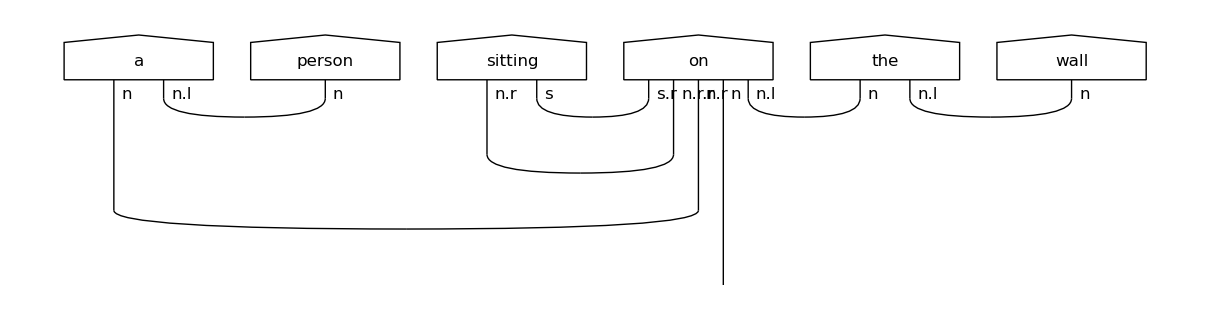

↓ sample sentence diagram without cups


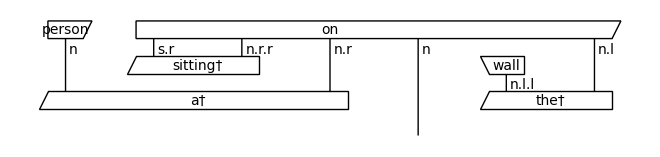

In [121]:
print('↓ sample sentence diagram with cups')
raw_sentence_diagrams[5].draw(figsize=(14, 3), fontsize=12)

print('↓ sample sentence diagram without cups')
train_diagrams_sentence[5].draw()

In [123]:
train_circuits_sentence = [ansatz_sentence(diagram) for diagram in train_diagrams_sentence]

↓ sample sentence circuit


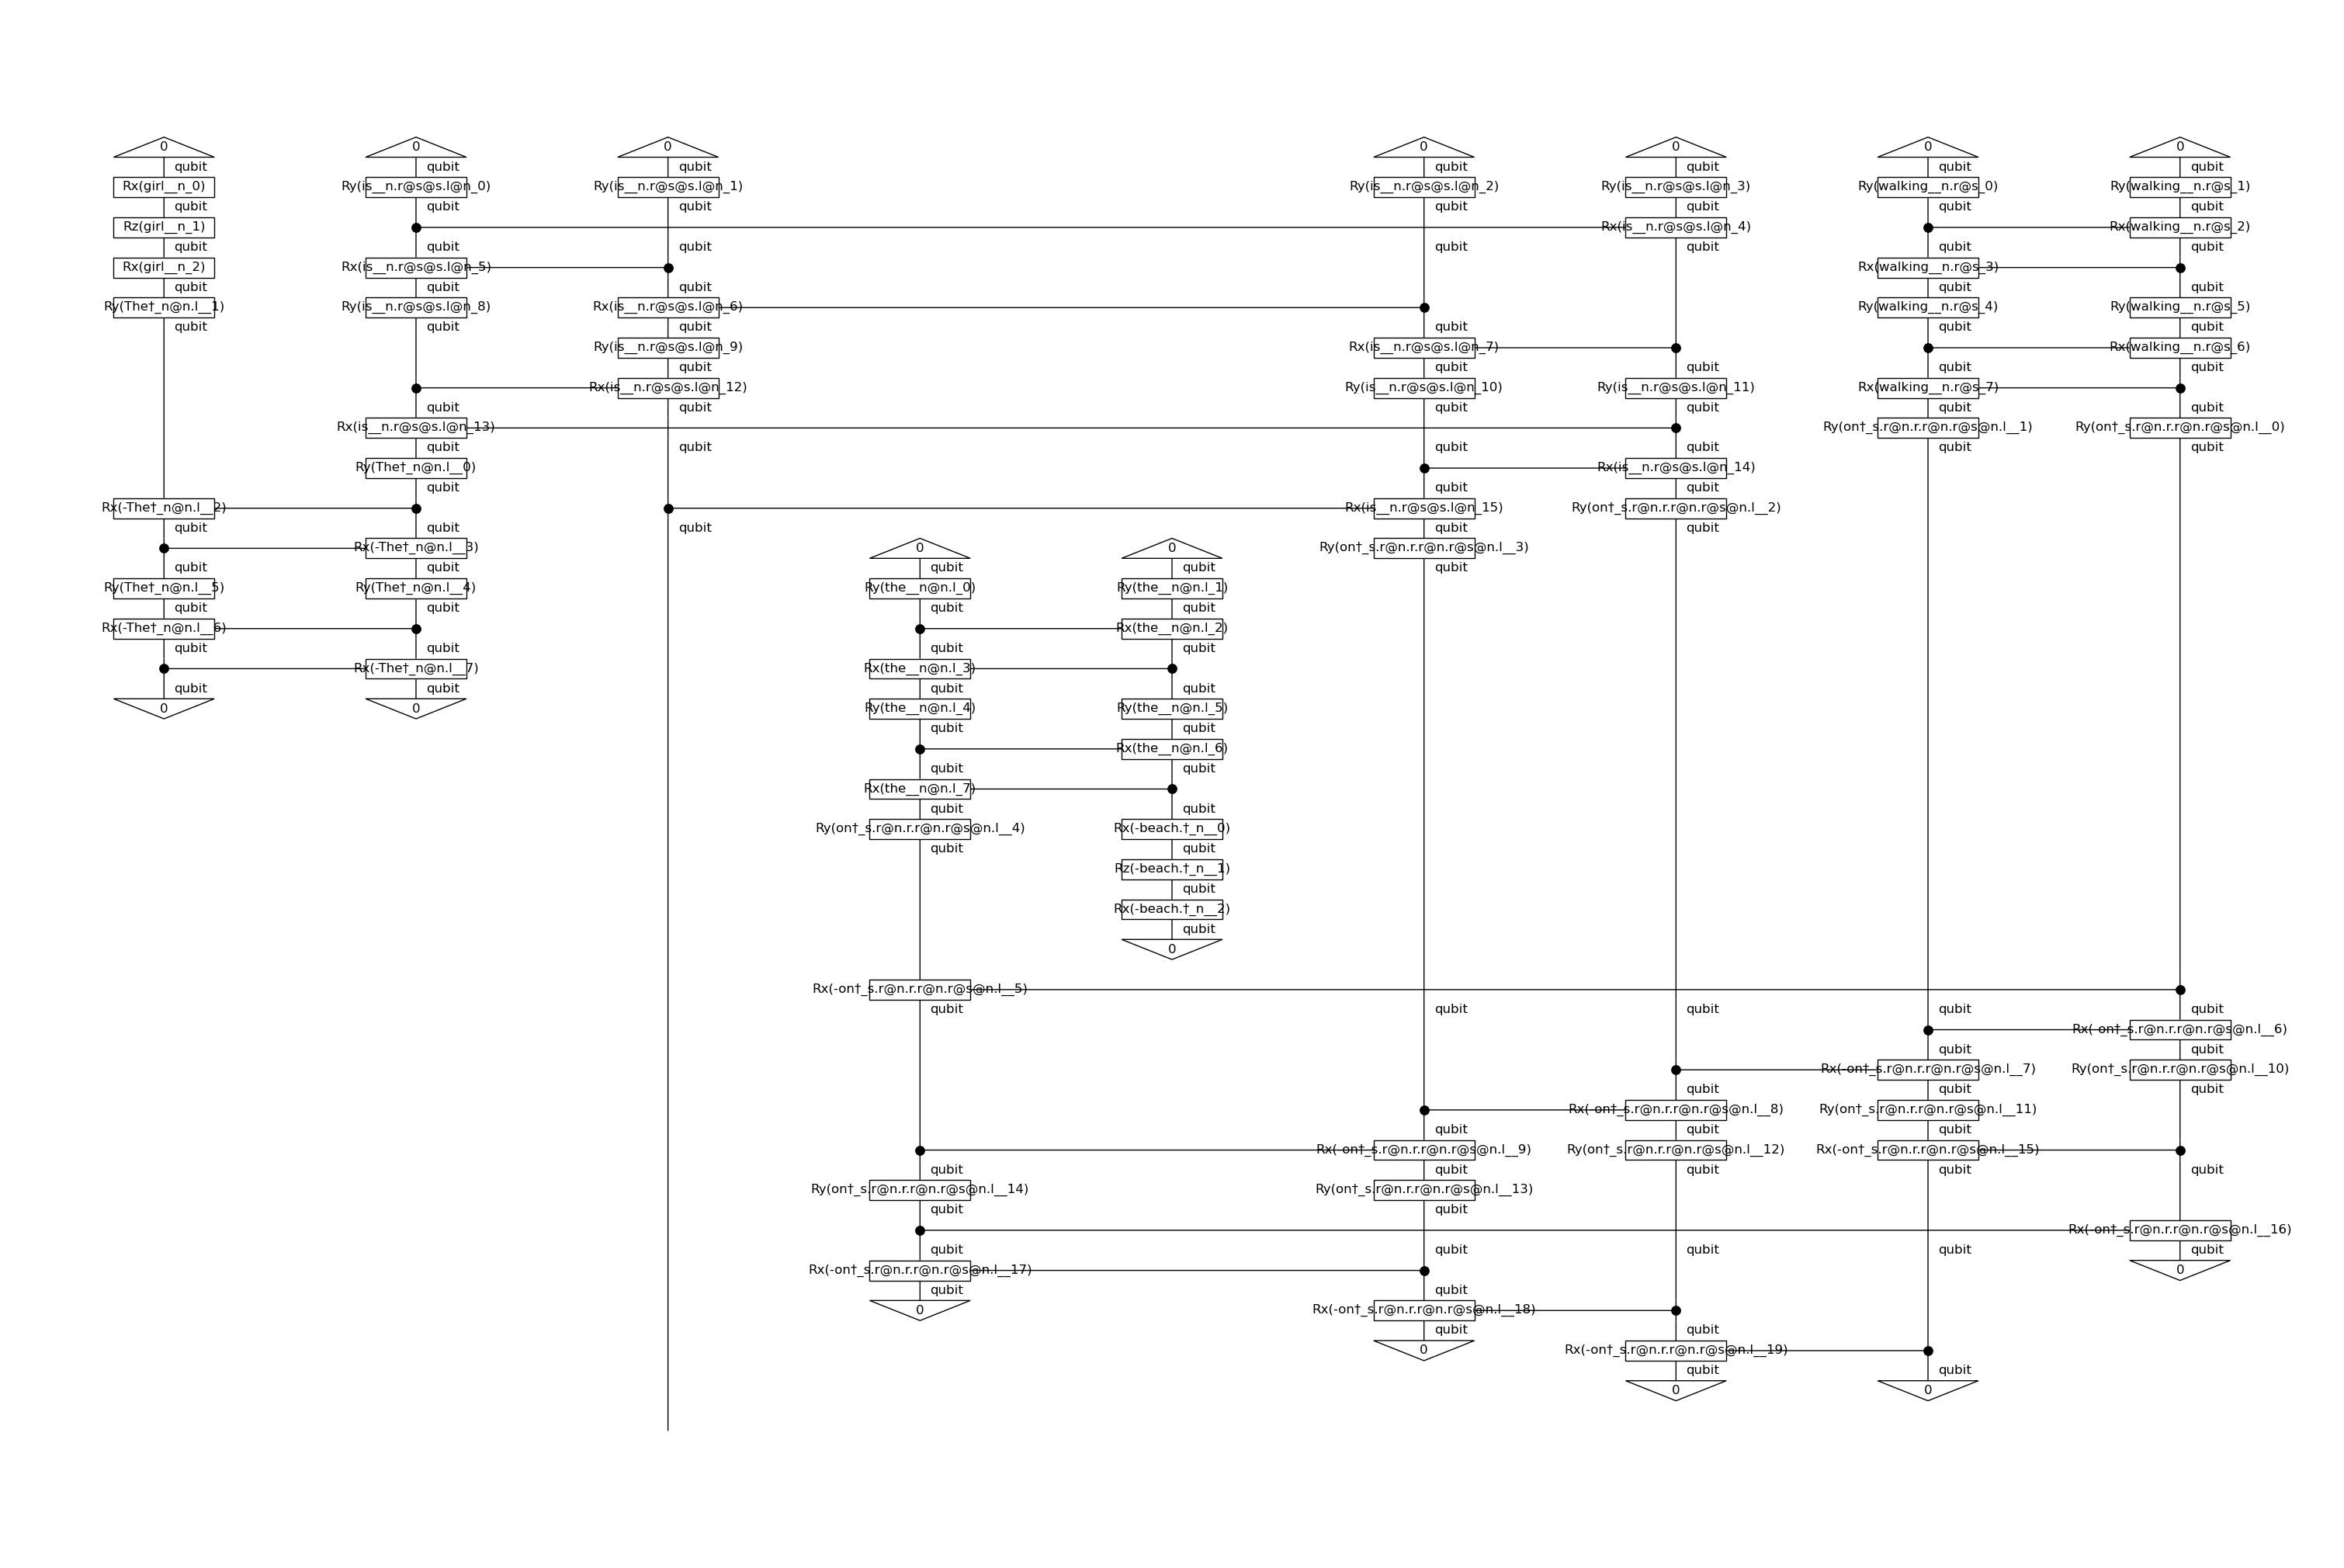

In [124]:
print('↓ sample sentence circuit')
train_circuits_sentence[10].draw(figsize=(30, 20), fontsize=12)

Images 

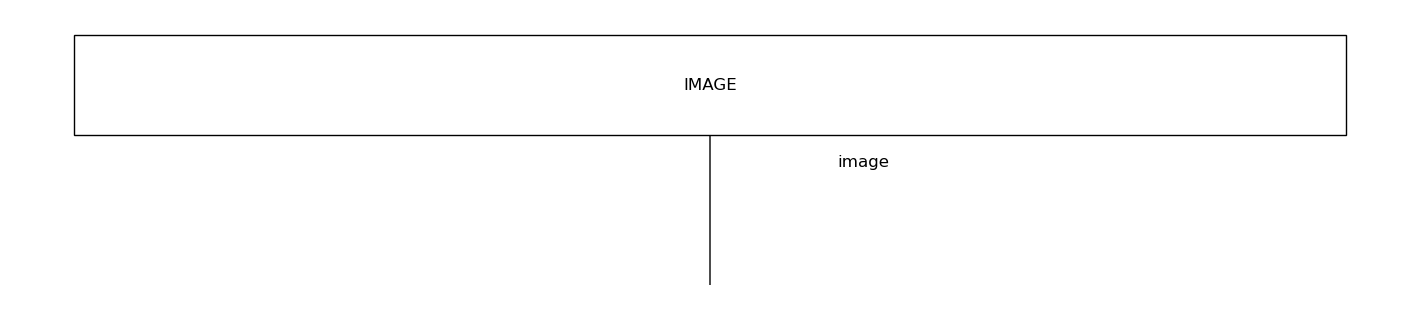

↓ template image circuit


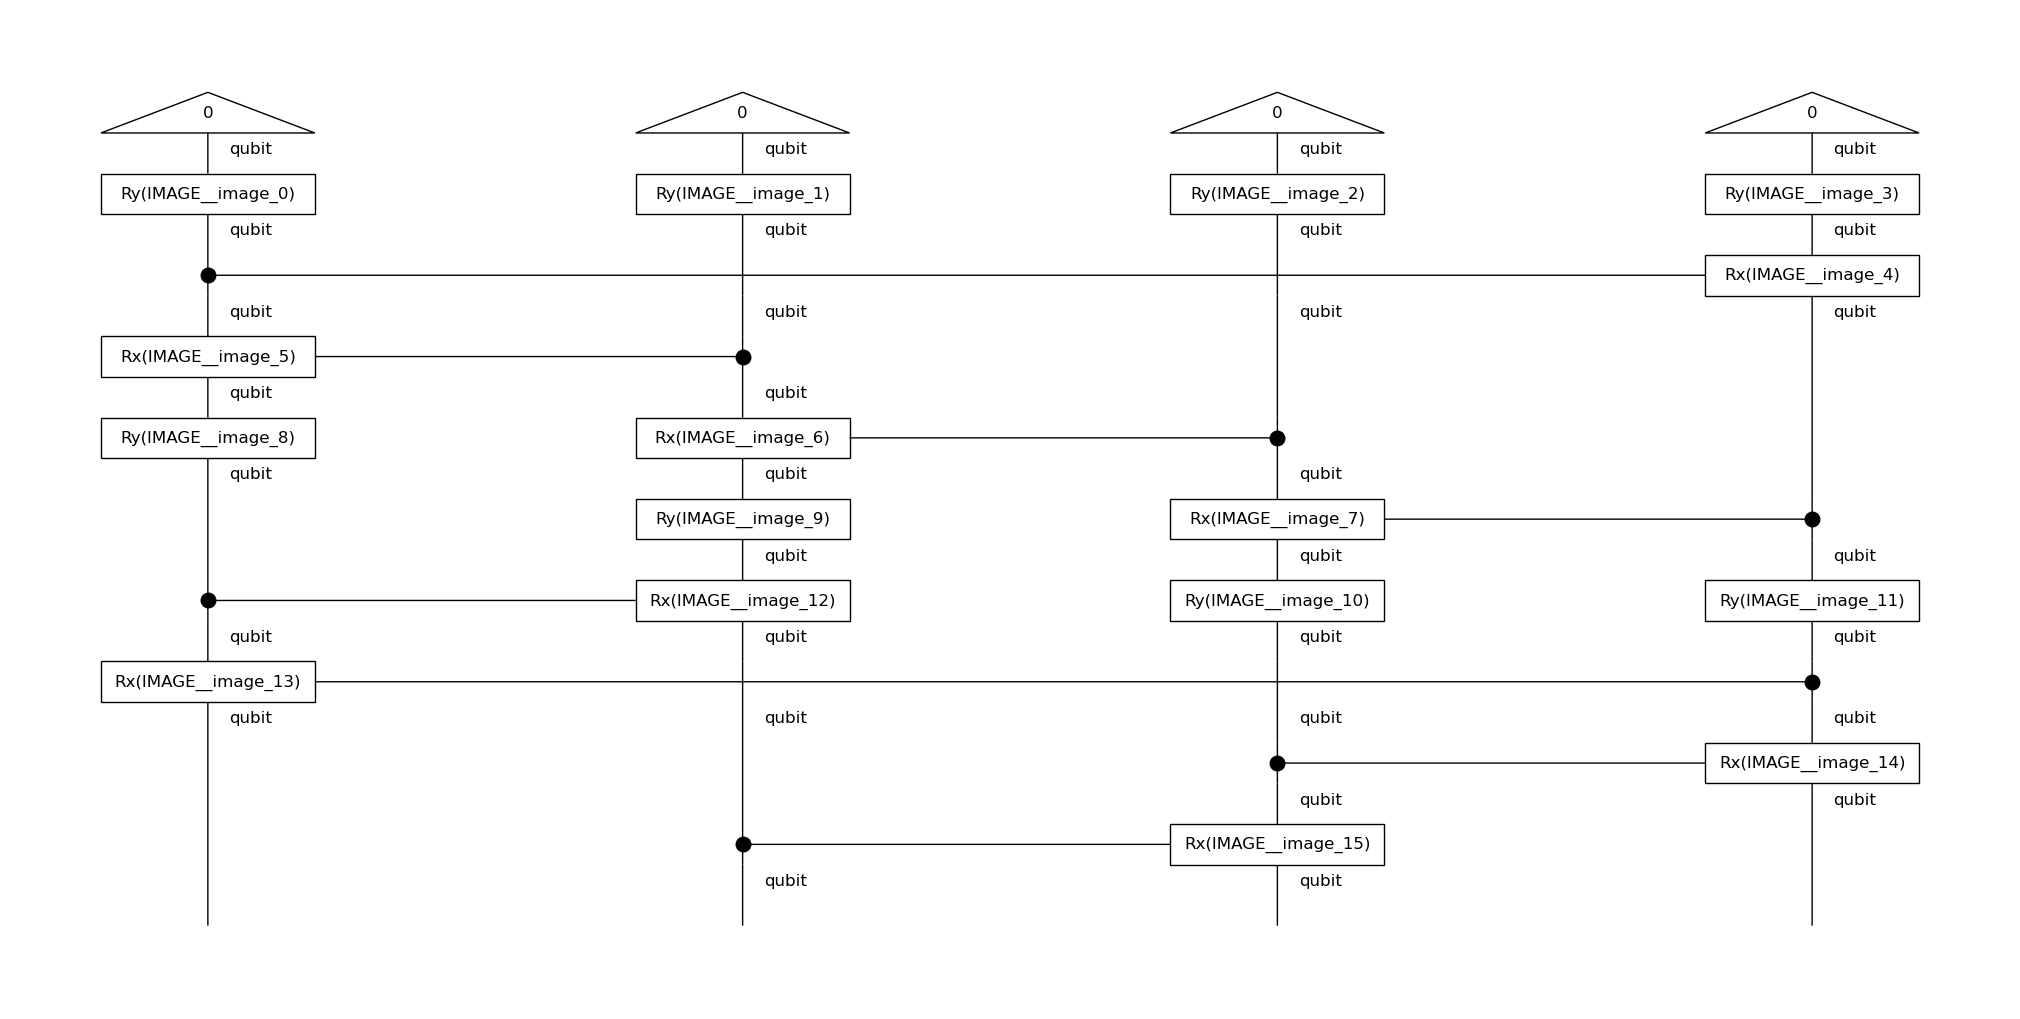

circuit for positive image: complete
FIX IT -> circuit for negative image uses positive image


In [125]:
# Create a new image Ty
image_type = Ty("image")
image_box = Box(name = "IMAGE", dom = Ty(), cod= image_type)
image_box.draw(figsize=(14, 3), fontsize=12)

# Create template Ansatz
ansatz = Sim14Ansatz({image_type: 4}, n_layers=1)
image_circ = ansatz(image_box)
print('↓ template image circuit')
image_circ.draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit POSITIVE
images_pos = clean_df["image_pos"]
train_circuits_imagePos = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in images_pos]
print("circuit for positive image: complete")
# train_circuits_imagePos[9].draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit NEGATIVE
images_neg = clean_df["image_pos"]
train_circuits_imageNeg = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in images_neg]
print("FIX IT -> circuit for negative image uses positive image")
# train_circuits_imageNeg[9].draw(figsize=(20, 10), fontsize=12)



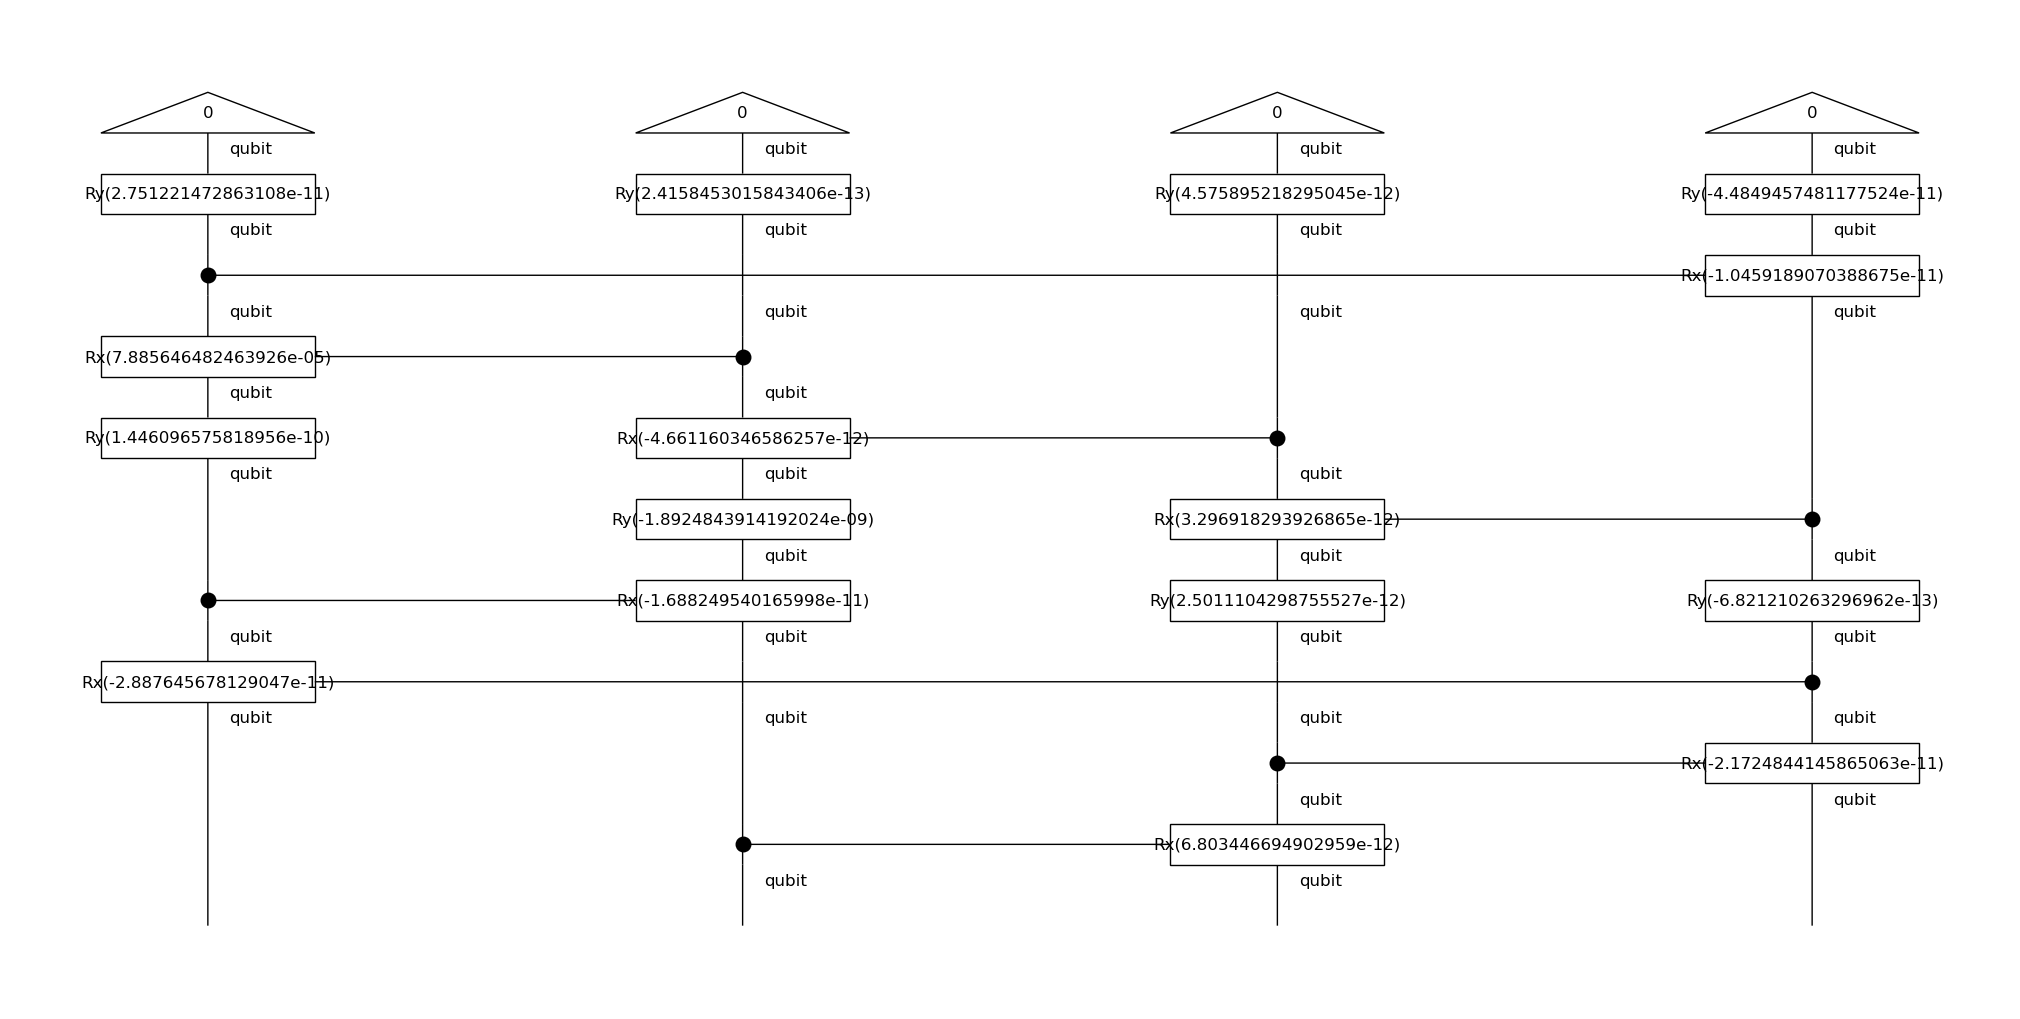

In [126]:
train_circuits_imageNeg[1].draw(figsize=(20, 10), fontsize=12)

merge sentence @ image

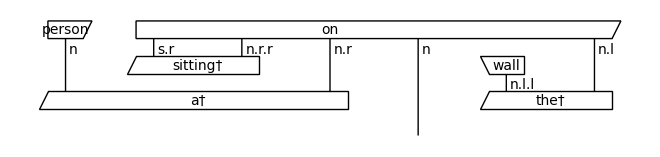

In [134]:
train_diagrams_sentence[5].draw()

In [142]:
# Create new Type
image_type = Ty("image")
output_type = Ty("output")
comparison_box = Box("COMPARISON", AtomicType.SENTENCE @ image_type @ image_type, output_type)

# diagrams = [(sentence_diagram @ image_type @ image_type) >> comparison_box for sentence_diagram in train_diagrams_sentence]

# diagram = raw_sentence_diagrams[5] @ image_type @ image_type >> comparison_box

# Draws diagram with comparison box (0,1) - Sentence digarm and comparison box is in grammar form
diagrams = []
print("=======================")
for num in range(len(clean_df)):
    try:
        temp = train_diagrams_sentence[num] @ image_type @ image_type >> comparison_box
        diagrams.append(temp)
    except Exception as e:
        print(f"Error at index {num}: {e}")
print("=======================")


# diagrams = [(sentence_diagram @ image_type @ image_type) >> comparison_box for sentence_diagram in train_diagrams_sentence]
# print('↓ template merge diagram : (sentence, image1, image2)')
# diagrams[0].draw(figsize=(20, 10), fontsize=12)

# # Ansatz & Circuit
ansatz = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, image_type : 4, output_type : 1},  n_layers=1)
temp_circuit = []
print("\n=======================")
for num in range(len(clean_df)):
    try:
        temp = ansatz(diagram[num])
        temp_circuit.append(temp)
    except Exception as e:
        print(f"Error at index {num}: {e}")
print("=======================")
# temp_circuit = [ansatz(diagram) for diagram in diagrams]


Error at index 5: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 6: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 7: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 22: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 23: Diagram 0 (cod=n.r @ s @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 24: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 25: Diagram 0 (cod=n.r @ s @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 49: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 55: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at i

In [ ]:
print("sample circuit : (sentence, image_type , image_type)")
temp_circuit[3].draw(figsize=(60, 40), fontsize=18, draw_type_labels = False )